#### Проанализировать продажи, найти город, приносящий максимальный доход и спрогнозировать CLV по клиентам этого города.

In [ ]:
#### Экспоративный анализ даных:

In [162]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# import altair as alt
import plotly.express as px
#  import xlrd
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import datetime
plt.style.use("ggplot")
np.random.seed(42)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./datasets/superstore/superstore_csv.csv', encoding='Windows-1251') #, sep=' ')

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,08/11/2018,11/11/2018,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2018-152156,08/11/2018,11/11/2018,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2018-138688,12/06/2018,16/06/2018,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2017-108966,11/10/2017,18/10/2017,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2017-108966,11/10/2017,18/10/2017,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [167]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,08/11/2018,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


#### Изучаю данные:

In [20]:
df.duplicated().sum()

0

In [4]:
df.isna().sum()/df.shape[0]

Row ID            0.000000
Order ID          0.000000
Order Date        0.000000
Ship Date         0.000000
Ship Mode         0.000000
Customer ID       0.000000
Customer Name     0.000000
Segment           0.000000
Country/Region    0.000000
City              0.000000
State             0.000000
Postal Code       0.001101
Region            0.000000
Product ID        0.000000
Category          0.000000
Sub-Category      0.000000
Product Name      0.000000
Sales             0.000000
Quantity          0.000000
Discount          0.000000
Profit            0.000000
dtype: float64

In [ ]:
#### Считаю что для цели исследования колонка индекс не представляет ценности.

In [ ]:
#### Привожу колонку с датой отгрузки к типу datetime:

In [130]:
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [22]:
#### Смотрю на топ 10 регионов по количеству транзакций:

In [5]:
df.Region.unique()

array(['South', 'West', 'Central', 'East'], dtype=object)

In [37]:
sales_by_region = df.groupby('Region', as_index=False) \
                    .agg({'Sales': 'sum'}) \
                    .sort_values('Sales')

purchases_by_region = df.groupby('Region', as_index=False) \
                        .agg({'Order ID': pd.Series.nunique}) \
                        .rename(columns={'Order ID': 'Number_of_purchases'}) \
                        .sort_values('Number_of_purchases')

In [ ]:
#### Смотрю продажи и количество покупок по регионам:

<AxesSubplot:xlabel='Region', ylabel='Number_of_purchases'>

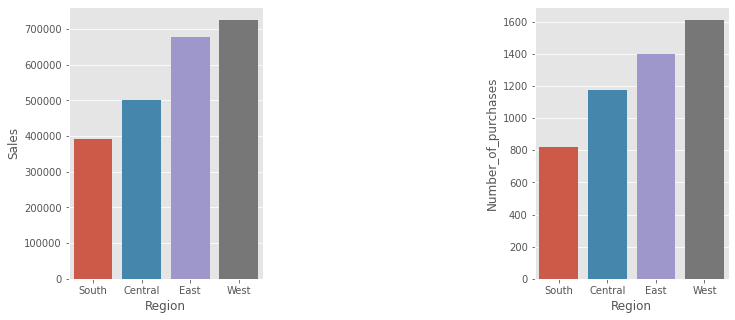

In [38]:
plt.figure(figsize=(16,5))

plt.subplot(141)
sns.barplot(x='Region', y='Sales', data=sales_by_region)

plt.subplot(143)
sns.barplot(x='Region', y='Number_of_purchases', data=purchases_by_region)

In [ ]:
#### Топ-10 городов по количеству покупок и по объему продаж:

In [78]:
sales_by_city = df.groupby('City', as_index=False) \
                  .agg({'Sales': 'sum'}) \
                  .sort_values('Sales') \
                  .tail(10)


purchases_by_city = df.groupby('City', as_index=False) \
                      .agg({'Order ID': 'nunique'}) \
                      .rename(columns={'Order ID': 'Number_of_purchases'}) \
                      .sort_values('Number_of_purchases')\
                      .tail(10)

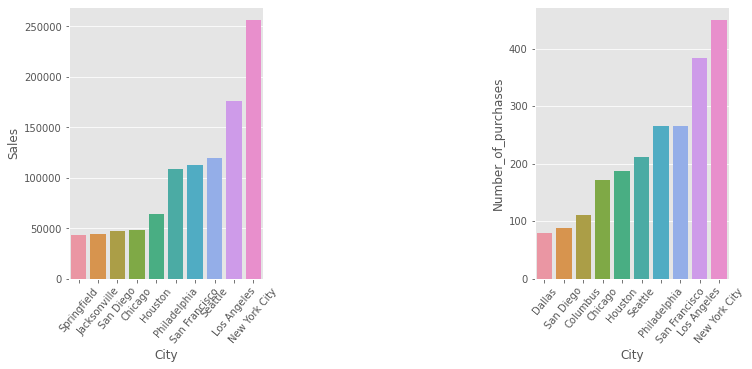

In [163]:
plt.figure(figsize=(16,5))

plt.subplot(141)
sns.barplot(x='City', y='Sales', data=sales_by_city)
plt.xticks(rotation=50)

plt.subplot(143)
sns.barplot(x='City', y='Number_of_purchases', data=purchases_by_city)
plt.xticks(rotation=50)

warnings.filterwarnings('ignore')

In [ ]:
#### Смотрю распределение среднего чека по городам:

In [173]:
px.scatter(df[['City', 'Order ID', 'Sales', 'Customer ID']].groupby('City').mean(),
                      y = 'Sales', size = 'Sales', title = "Avg price by Country", opacity = 0.50)

In [81]:
cities = df.City.unique()

IndexError: list index out of range

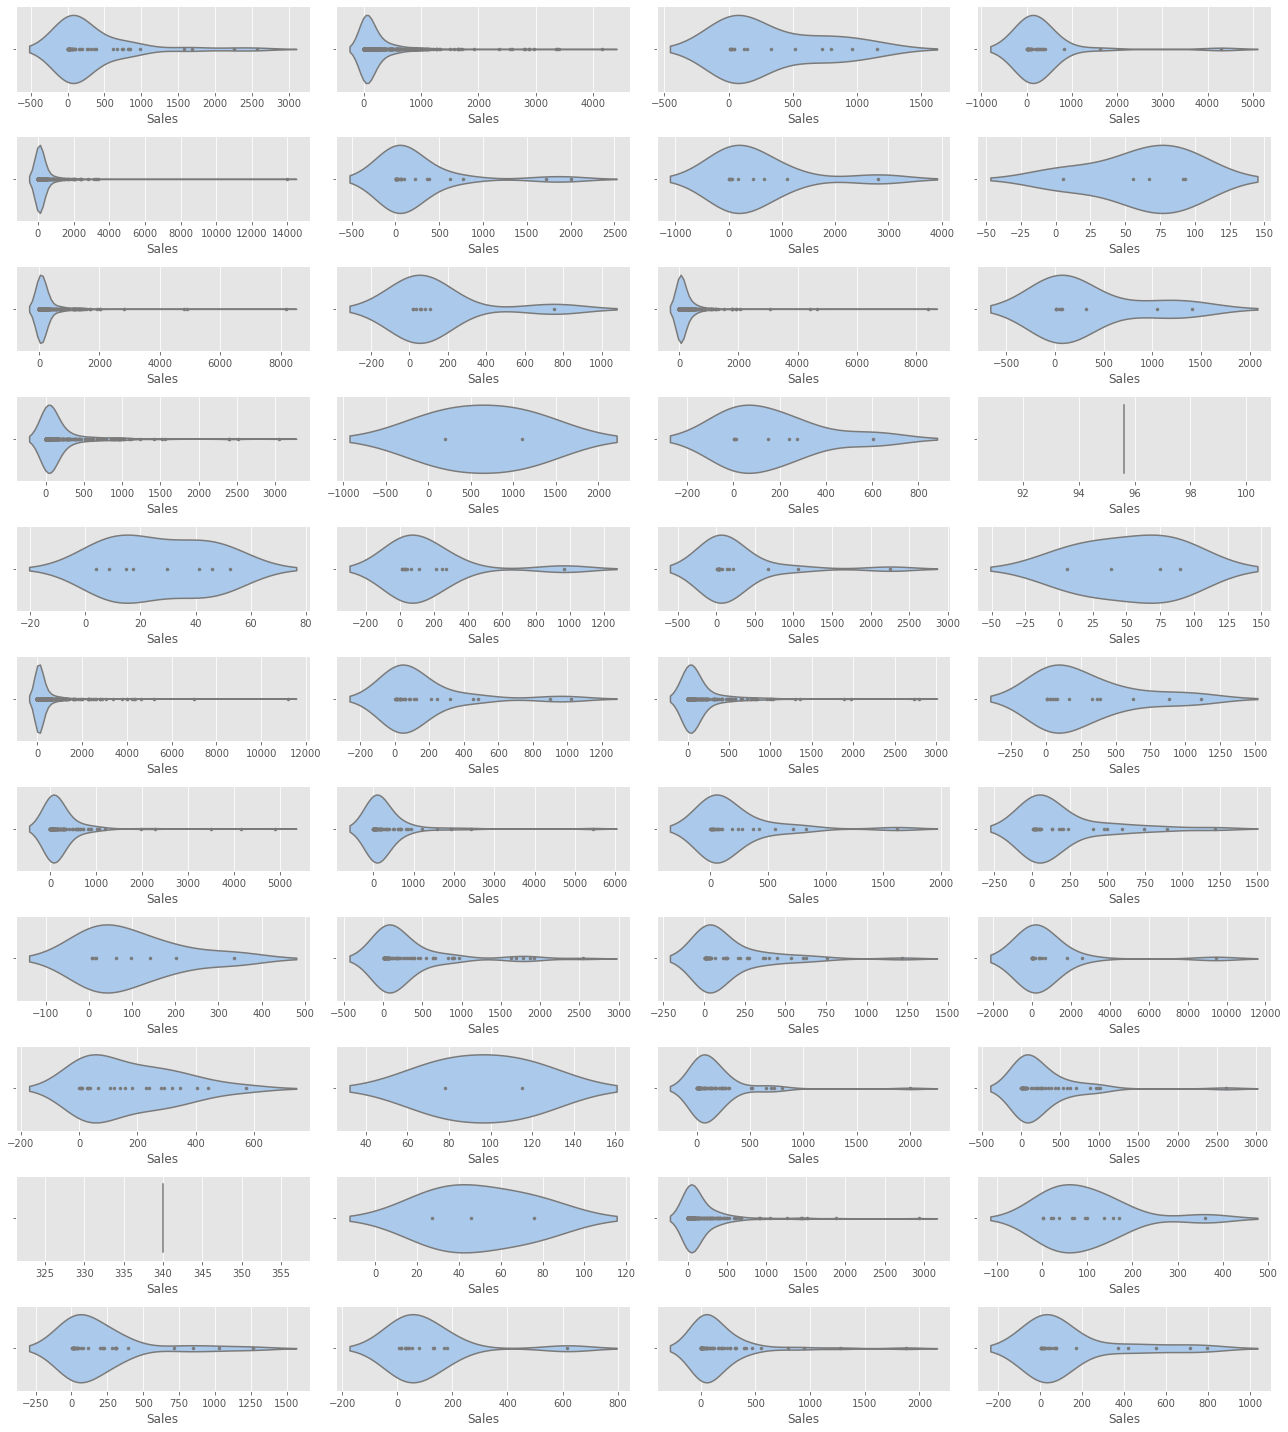

In [83]:

fig, ax = plt.subplots(11, 4, figsize=(18, 20))

axes = [axes_row for axes in ax for axes_row in axes]


for i, c in enumerate(cities):
    sns.violinplot(x='Sales', data=df[df['City'] == c], ax = axes[i], inner = 'point', palette = 'pastel')
    #axes_[i].set_title(c + ' ' + 'Price Distribution')
    plt.tight_layout()

In [ ]:
#### Нахожу самый продаваемый товар:

In [90]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,08/11/2018,11/11/2018,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


<AxesSubplot:xlabel='Product Name'>

<Figure size 1152x576 with 0 Axes>

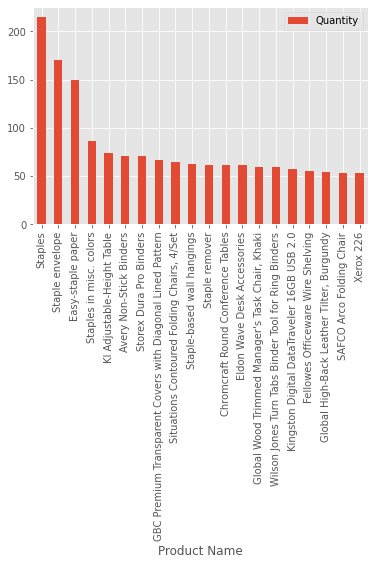

In [121]:
plt.figure(figsize=(16,8))

df.groupby('Product Name') \
  .agg({'Quantity': 'sum'})\
  .sort_values('Quantity', ascending=False) \
  .head(20) \
  .plot(kind='bar')

In [125]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,08/11/2018,11/11/2018,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


In [135]:
temp_data = df.copy()

In [175]:
temp_data.loc[:,'Month'] = df['Ship Date'].dt.month
temp_data.loc[:, 'Time'] = df['Ship Date'].dt.month
temp_data.loc[:, 'Year'] = df['Ship Date'].dt.year
temp_data.loc[:, 'Day'] = df['Ship Date'].dt.day
temp_data.loc[:, 'Quarter'] = df['Ship Date'].dt.quarter
temp_data.loc[:, 'Day of week'] = df['Ship Date'].dt.dayofweek

In [176]:
dayofweek_mapping = dict({0: 'Monday',
                           1: 'Tuesday',
                           2: 'Wednesday',
                           3: 'Thursday',
                           4: 'Friday',
                           5: 'Saturday',
                           6: 'Sunday'})

In [177]:
temp_data['day of week'] = temp_data['Day of week'].map(dayofweek_mapping)

In [1]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
sns.lineplot(x='Month', 
             y='Quantity', 
             data=temp_data.groupby('Month') \
                           .sum('Quantity'), marker='.', color='olive')

plt.axvline(11, color='g',  linestyle='--', alpha=0.3)
plt.title('trnsactions by month')
plt.subplot(3,2,2)
temp_data.groupby('Quarter').sum()['Quantity'].plot(kind='bar')


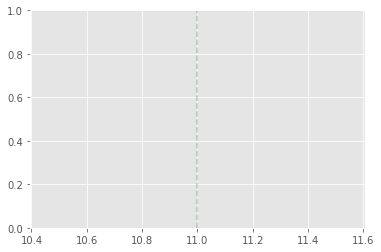

In [153]:
plt.axvline(11, color='g',  linestyle='--', alpha=0.3)

In [112]:
max_freq = df.groupby('Product Name', as_index=False) \
  .agg({'Product ID': 'count'}) \
  .sort_values('Product ID', ascending=False) \
  ['Product ID'] \
  .head(1) \
  .item()

df.iloc[max_freq]['Product Name']

'LF Elite 3D Dazzle Designer Hard Case Cover, Lf Stylus Pen and Wiper For Apple Iphone 5c Mini Lite'

In [105]:
df.iloc[max_freq]['Product Name']

'LF Elite 3D Dazzle Designer Hard Case Cover, Lf Stylus Pen and Wiper For Apple Iphone 5c Mini Lite'